In [30]:
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth, kilometer2degrees
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [31]:
path = '/Users/sydneydybing/SW4/strain/'

# Event and Station locations

In [32]:
# Maximum frequency you want to model
freqMax = 0.25 #Hz

In [33]:
sta_file = 'sw4_cas-stations.txt'
stas_sub = pd.read_csv(path + sta_file, delimiter = '\t', skiprows = 1, names = ['BNUM', 'LONG', 'LAT', 'BSM_Depth(m)'])


In [34]:
stas_sub

,BNUM,LONG,LAT,BSM_Depth(m)
0,UWFH,-123.013702,48.545502,-8.0
1,SJIF,-123.022499,48.522999,-23.8
2,MKAH,-124.589104,48.370701,-18.0
3,OCP,-124.625198,48.297901,-487.0
4,BRUIN,-124.258598,48.251701,-13.0
...,...,...,...,...
73,FISH2,-123.499397,45.927502,-146.3
74,CNNB,-123.960503,45.888100,-13.0
75,NECAN,-123.823998,45.865299,-514.7
76,ELSIE,-123.544899,45.855999,-198.3


# Plot Events and Stations

In [35]:
# Rupture extent

rupt = np.genfromtxt(path + 'cascadia_m8.rupt')
# rupt
slip = (rupt[:,8]**2 + rupt[:,9]**2) ** 0.5
r = np.where(slip != 0)[0]
# print(i)
# plt.scatter(rupt[:,1][r], rupt[:,2][r])

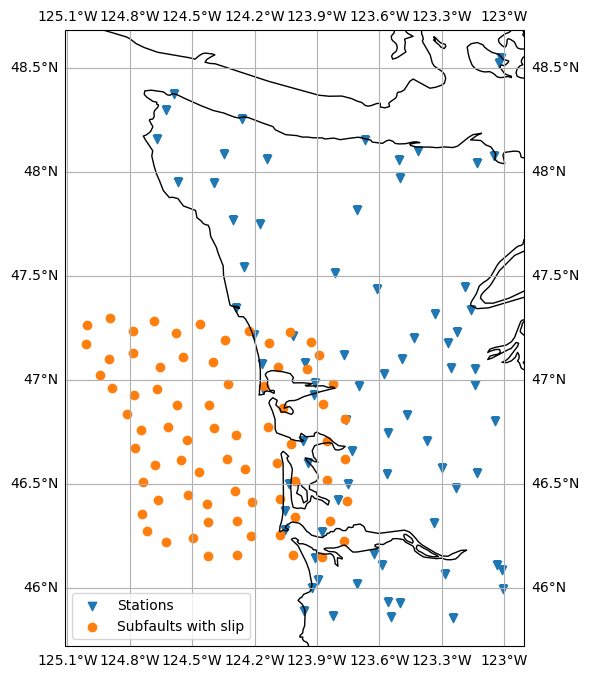

In [36]:
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = ccrs.PlateCarree())
plt.scatter(stas_sub['LONG'], stas_sub['LAT'], marker = 'v', label = 'Stations')
plt.scatter(rupt[:,1][r], rupt[:,2][r], marker = 'o', label = 'Subfaults with slip')
# # Add station labels
# # [plt.text(i, j, f'{name}', va = 'top', ha = 'left') for (i, j, name) in zip(stas_sub['LONG'], stas_sub['LAT'], stas_sub['BNUM'])]

ax.legend(loc = 'lower left')
ax.coastlines()
gl = ax.gridlines(draw_labels = True)
Plotlims = ax.get_extent()
plt.show()

In [37]:
# These values are roughly the rectangle that encompasses all of our points plus a little buffer
Plotlims

(-125.109618835, -122.903418465, 45.718479725499996, 48.680121804500004)

# Velocity Model Stuff

In [38]:
# Load velocity model data. Doing simple block model for my project - no topography or pfile
vmod = pd.read_csv(path + 'cascadia.mod', sep = '\t', names = ['Thickness', 'Vs', 'Vp', 'rho', 'Qs', 'Qp'])
# vmod
thicknesses = vmod.Thickness.values
Vps = vmod.Vp.values
Vss = vmod.Vs.values
rhos = vmod.rho.values
Qps = vmod.Qp.values
Qss = vmod.Qs.values
vmod

,Thickness,Vs,Vp,rho,Qs,Qp
0,0.3,1.75,3.03,2.20,87.5,175
1,1.2,2.00,3.46,2.30,100.0,200
2,2.0,2.60,4.50,2.50,130.0,260
3,2.0,2.94,5.10,2.60,147.0,294
4,2.5,3.29,5.70,2.65,164.5,329
5,3.5,3.64,6.30,2.70,182.0,364
6,4.5,3.80,6.60,2.80,190.0,380
7,4.0,3.89,6.73,2.85,194.5,389
8,5.0,3.96,6.86,2.90,198.0,396
9,16.0,4.01,6.95,2.90,200.5,401


In [39]:
# Add column to vmod with Vp/Vs ratios

Vp_Vses = []

for i in range(len(vmod)):
    Vp = Vps[i]
    Vs = Vss[i]
    Vp_Vs = Vp/Vs
    Vp_Vses.append(Vp_Vs)

vmod['Vp/Vs'] = Vp_Vses
vmod

,Thickness,Vs,Vp,rho,Qs,Qp,Vp/Vs
0,0.3,1.75,3.03,2.20,87.5,175,1.731429
1,1.2,2.00,3.46,2.30,100.0,200,1.730000
2,2.0,2.60,4.50,2.50,130.0,260,1.730769
3,2.0,2.94,5.10,2.60,147.0,294,1.734694
4,2.5,3.29,5.70,2.65,164.5,329,1.732523
5,3.5,3.64,6.30,2.70,182.0,364,1.730769
6,4.5,3.80,6.60,2.80,190.0,380,1.736842
7,4.0,3.89,6.73,2.85,194.5,389,1.730077
8,5.0,3.96,6.86,2.90,198.0,396,1.732323
9,16.0,4.01,6.95,2.90,200.5,401,1.733167


In [40]:
# Assign some values from the velocity model for later
# We need Vs min for computing the desired resolution for the domain
# We need the max Vp/Vs ratio, becuase the number of points per wavelength you need for good resolution is higher for high Vp/Vs
vs_min = vmod['Vs'].min()
VpVs_max = vmod['Vp/Vs'].max()
ind = vmod.index[vmod['Vp/Vs'] == VpVs_max] # Find row with the max to get the Vp and Vs values
Vp_fromVpVsmax = vmod['Vp'][ind]
Vs_fromVpVsmax = vmod['Vs'][ind]
val = (Vs_fromVpVsmax**2) / (Vp_fromVpVsmax**2 - 2*Vs_fromVpVsmax**2)

val

6    0.983651
dtype: float64

If val here was <0.1 then we'd have to worry about needing wayyyyy more points per wavelength (like 40 instead of 6-10), but we are okay here

See ref: H.-O. Kreiss and N.A. Petersson. Boundary estimates for the elastic wave equation in almost incompressible materials. SIAM J. Numer. Anal., 50:1556–1580, 2012.

In [41]:
# Write new block lines

z1 = 0

for i in range(len(vmod)):
    thickness = thicknesses[i] * 1000
    Vp = int(Vps[i] * 1000)
    Vs = int(Vss[i] * 1000)
    rho = int(rhos[i] * 1000)
    Qp = int(Qps[i] * 1000)
    Qs = int(Qss[i] * 1000)

    z1 = int(z1)

    z2 = int(z1 + thickness)

    if i == range(len(vmod))[-1]:
        line = 'block vp=' + str(Vp) + ' vs=' + str(Vs) + ' rho=' + str(rho) + ' z1=' + str(z1)
    else:
        line = 'block vp=' + str(Vp) + ' vs=' + str(Vs) + ' rho=' + str(rho) + ' z1=' + str(z1) + ' z2=' + str(z2)
    z1 += thickness

    print(line)

depth_max = z2


block vp=3030 vs=1750 rho=2200 z1=0 z2=300
block vp=3460 vs=2000 rho=2300 z1=300 z2=1500
block vp=4500 vs=2600 rho=2500 z1=1500 z2=3500
block vp=5100 vs=2940 rho=2600 z1=3500 z2=5500
block vp=5700 vs=3290 rho=2650 z1=5500 z2=8000
block vp=6300 vs=3640 rho=2700 z1=8000 z2=11500
block vp=6600 vs=3800 rho=2800 z1=11500 z2=16000
block vp=6730 vs=3890 rho=2850 z1=16000 z2=20000
block vp=6860 vs=3960 rho=2900 z1=20000 z2=25000
block vp=6950 vs=4010 rho=2900 z1=25000 z2=41000
block vp=7800 vs=4500 rho=3000 z1=41000


# Plot bounds of Velocity Model with station locations

In [42]:
Plotlims

(-125.109618835, -122.903418465, 45.718479725499996, 48.680121804500004)

In [43]:
# Station/event box
# Setup points for box for domain from above with only event and stations
x_evtsta = [Plotlims[0], Plotlims[1], Plotlims[1], Plotlims[0], Plotlims[0]]
y_evtsta = [Plotlims[2], Plotlims[2], Plotlims[3], Plotlims[3], Plotlims[2]]

# Add buffer to make it bigger, since we need the supergrid to be farther out at this max frequency
evtsta_buffer = 0.5
x_model_domain = [Plotlims[0]-evtsta_buffer, Plotlims[1]+evtsta_buffer, Plotlims[1]+evtsta_buffer, Plotlims[0]-evtsta_buffer, Plotlims[0]-evtsta_buffer]
y_model_domain = [Plotlims[2]-evtsta_buffer, Plotlims[2]-evtsta_buffer, Plotlims[3]+evtsta_buffer, Plotlims[3]+evtsta_buffer, Plotlims[2]-evtsta_buffer]

In [44]:
# Velocity model box
# For my project, I'm just using a block model so I can artificially set this up based on the station locs with a buffer
vmod_buffer = 0.3 # degrees - 0.1 degrees = 10 km
x_vmod = [Plotlims[0]-vmod_buffer, Plotlims[1]+vmod_buffer, Plotlims[1]+vmod_buffer, Plotlims[0]-vmod_buffer, Plotlims[0]-vmod_buffer]
y_vmod = [Plotlims[2]-vmod_buffer, Plotlims[2]-vmod_buffer, Plotlims[3]+vmod_buffer, Plotlims[3]+vmod_buffer, Plotlims[2]-vmod_buffer]

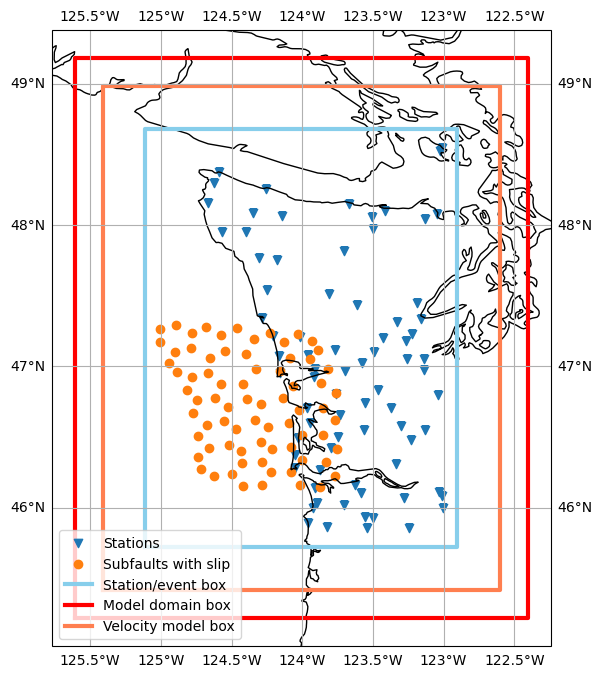

In [45]:
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = ccrs.PlateCarree())

plt.scatter(stas_sub['LONG'], stas_sub['LAT'], marker = 'v', label = 'Stations')
plt.scatter(rupt[:,1][r], rupt[:,2][r], marker = 'o', label = 'Subfaults with slip')

ax.plot(x_evtsta, y_evtsta, color = 'skyblue', lw = 3, label = 'Station/event box')
ax.plot(x_model_domain, y_model_domain, color = 'red', lw = 3, label = 'Model domain box')
ax.plot(x_vmod, y_vmod, color = 'coral', lw = 3, label = 'Velocity model box')
ax.legend(loc = 'lower left')

ax.coastlines()
gl = ax.gridlines(draw_labels = True)

plt.show()

# Grid Spacing Math

In [46]:
# This is the relationship from the sw4 manual section 4.5, p 28
# npts should be between 6 and 10

def get_step_size(frequency_max, npts, Vs_min):
    H = Vs_min * 1000 / (npts * frequency_max)
    return H
    
step_size = get_step_size(freqMax, 10, vs_min)
print(f"Model grid spacing is {step_size} m ")

Model grid spacing is 700.0 m 


Based on the grid spacing, we can now compute the thickeness of the supergrid layer. The supergrid layers are SUPER important because they help damp reflections on the edges of the domain and dramatically decreases the size of the domain you need and decreases computational time. The supergrid points are PART of your model domain. Default number of supergrid points is 30, less than 20 points will make your solution numerically unstable. Long wavelengths are harder to supress than short wavelengths

In [47]:
npts_supergrid = 30
supergrid_thickness = step_size * npts_supergrid
supergrid_thickness_deg = np.round(kilometer2degrees(supergrid_thickness/1000), 4)
print(f"Do not put event sources or receivers in the outer {supergrid_thickness} m of the domain \nor a buffer of ~{supergrid_thickness_deg} degrees")

Do not put event sources or receivers in the outer 21000.0 m of the domain 
or a buffer of ~0.1889 degrees


The thickness of our supergrid layer is a lot smaller than the domain we are looking at so I think we can run with the values of lats and lons stored in x1 and y1 (the event/station box)

In [48]:
x_model_domain

[-125.609618835,
 -122.403418465,
 -122.403418465,
 -125.609618835,
 -125.609618835]

In [49]:
y_model_domain

[45.218479725499996,
 45.218479725499996,
 49.180121804500004,
 49.180121804500004,
 45.218479725499996]

In [50]:
Plotlims

(-125.109618835, -122.903418465, 45.718479725499996, 48.680121804500004)

In [51]:
lon_min = np.min(x_model_domain)
lon_max = np.max(x_model_domain)
lat_min = np.min(y_model_domain)
lat_max = np.max(y_model_domain)

# Setup points for box for model domain from above
x_sgrid = [x_model_domain[0]+supergrid_thickness_deg, x_model_domain[1]-supergrid_thickness_deg, x_model_domain[2]-supergrid_thickness_deg, x_model_domain[3]+supergrid_thickness_deg, x_model_domain[4]+supergrid_thickness_deg]
y_sgrid = [y_model_domain[0]+supergrid_thickness_deg, y_model_domain[1]+supergrid_thickness_deg, y_model_domain[2]-supergrid_thickness_deg, y_model_domain[3]-supergrid_thickness_deg, y_model_domain[4]+supergrid_thickness_deg]


# Plot with supergrid (and topography if I was including that - deleted some cells)

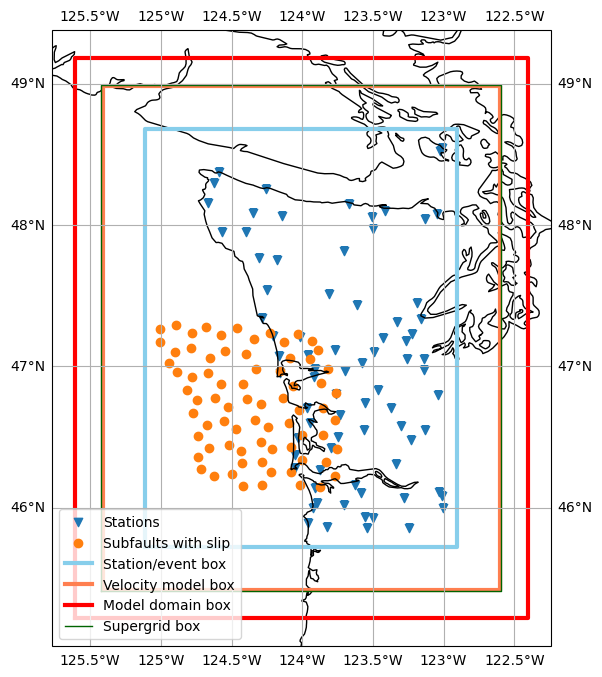

In [52]:
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = ccrs.PlateCarree())


plt.scatter(stas_sub['LONG'], stas_sub['LAT'], marker = 'v', label = 'Stations')
plt.scatter(rupt[:,1][r], rupt[:,2][r], marker = 'o', label = 'Subfaults with slip')

ax.plot(x_evtsta, y_evtsta, color = 'skyblue', lw = 3, label = 'Station/event box')
ax.plot(x_vmod, y_vmod, color = 'coral', lw = 3, label = 'Velocity model box')
ax.plot(x_model_domain, y_model_domain, color = 'red', lw = 3, label = 'Model domain box')
ax.plot(x_sgrid, y_sgrid, color = 'darkgreen', lw = 1, label = 'Supergrid box')
ax.legend(loc = 'lower left')

ax.coastlines()
gl = ax.gridlines(draw_labels = True)

plt.show()

# Aggregate Info for .in Files

### Grid Command info

In [53]:
print(lat_min)
print(lat_max)
print(lon_min)
print(lon_max)

45.218479725499996
49.180121804500004
-125.609618835
-122.403418465


In [54]:
# Compute cartesian locations for grid
Y,_,_ = gps2dist_azimuth(lat_min, lon_min, lat_min, lon_max) # SW4 orientation is weird. Fig 3.2 in manual
X,_,_ = gps2dist_azimuth(lat_min, lon_min, lat_max, lon_min)

print('GRID COMMAND')
print(f"Size of grid - x and y in m: {np.round(X,-1), np.round(Y,-1)}")
print(f"Maximum depth (z) from on velocity model in m: {depth_max}")
print(f"Origin - lat lon of lower left corner of model domain: {lat_min:.3f}, {lon_min:.3f}")
print(f"lat lon of upper right corner of model domain: {lat_max:.3f}, {lon_max:.3f}")
print('az = 0 for this project')
print(f"Model grid spacing (h) should be at least {int(step_size)} m for a frequency max of {freqMax} Hz")
print('')

print(f"grid x={int(X)} y={int(Y)} z=1030000 lat={lat_min:.3f} lon={lon_min:.3f} az=0 h={int(step_size)}")

GRID COMMAND
Size of grid - x and y in m: (440430.0, 251820.0)
Maximum depth (z) from on velocity model in m: 41000
Origin - lat lon of lower left corner of model domain: 45.218, -125.610
lat lon of upper right corner of model domain: 49.180, -122.403
az = 0 for this project
Model grid spacing (h) should be at least 700 m for a frequency max of 0.25 Hz

grid x=440434 y=251819 z=1030000 lat=45.218 lon=-125.610 az=0 h=700


/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_97987/1191106990.py:2: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  Y,_,_ = gps2dist_azimuth(lat_min, lon_min, lat_min, lon_max) # SW4 orientation is weird. Fig 3.2 in manual
/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_97987/1191106990.py:3: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  X,_,_ = gps2dist_azimuth(lat_min, lon_min, lat_max, lon_min)


### Receiver Output Command Info

In [55]:
# set output type
out = 'displacement'

In [56]:
for i in range(len(stas_sub)):
    print(f"rec lat={stas_sub['LAT'][i]:.3f} lon={stas_sub['LONG'][i]:.3f} depth=0 variables={out} file={stas_sub['BNUM'][i]} usgsformat=1 sacformat=0 writeEvery=50")
    

rec lat=48.546 lon=-123.014 depth=0 variables=displacement file=UWFH usgsformat=1 sacformat=0 writeEvery=50
rec lat=48.523 lon=-123.022 depth=0 variables=displacement file=SJIF usgsformat=1 sacformat=0 writeEvery=50
rec lat=48.371 lon=-124.589 depth=0 variables=displacement file=MKAH usgsformat=1 sacformat=0 writeEvery=50
rec lat=48.298 lon=-124.625 depth=0 variables=displacement file=OCP usgsformat=1 sacformat=0 writeEvery=50
rec lat=48.252 lon=-124.259 depth=0 variables=displacement file=BRUIN usgsformat=1 sacformat=0 writeEvery=50
rec lat=48.158 lon=-124.669 depth=0 variables=displacement file=OZET usgsformat=1 sacformat=0 writeEvery=50
rec lat=48.151 lon=-123.671 depth=0 variables=displacement file=STW usgsformat=1 sacformat=0 writeEvery=50
rec lat=48.100 lon=-123.414 depth=0 variables=displacement file=PCOL usgsformat=1 sacformat=0 writeEvery=50
rec lat=48.086 lon=-124.345 depth=0 variables=displacement file=OTR usgsformat=1 sacformat=0 writeEvery=50
rec lat=48.074 lon=-123.048 de

### Memory Calculations

Appendix B says roughly 208 bytes/grid point for runs with topography 

BUT "For parallel runs, the memory per grid point will be somewhat higher, because of duplicated
ghost points at the processor boundaries."

In [57]:
grid_pts = (X/step_size) * (Y/step_size) * (depth_max / step_size)
mem_per_point = 208
mem_gb = grid_pts * mem_per_point / 1e9
print(f"Rough approximation of memory is {np.round(mem_gb, 0)} GB for a maximum frequency of {freqMax} Hz")

Rough approximation of memory is 3.0 GB for a maximum frequency of 0.25 Hz


### Maximum Grid spacing

To have 30 super grid points on the outside of the domain and at least 60 actual grid points in domain, you can't have a step size for your grid higher than:

In [58]:
h_max = np.min([X/120, Y/120, depth_max/90])
h_max

455.55555555555554